# Alex Net

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..') # add the parent dir to path; needed to import the utils package
from utils.training import Callbacks
from utils.plotting import HistoryPlotter, ImagePlotter
from utils.preprocess import TFDS

import matplotlib.pyplot as plt
import numpy as np

### Preprocess the Dataset

#### 1. Split the dataset

In [2]:
(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.fashion_mnist.load_data()
class_label = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"}

# Convert them from (m,) to (m,1)
y_train = y_train.reshape((-1,1))
y_valid = y_valid.reshape((-1,1))

# Create test set from valid set
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.3)

print("x_train :", x_train.shape, "y_train :", y_train.shape)
print("x_valid :", x_valid.shape, "y_valid :", y_valid.shape)
print("x_test :", x_test.shape, "y_test : ", y_test.shape)

x_train : (60000, 28, 28) y_train : (60000, 1)
x_valid : (7000, 28, 28) y_valid : (7000, 1)
x_test : (3000, 28, 28) y_test :  (3000, 1)


#### 2. Convert the Lables to One-Hot Vectors

In [3]:
# convert the class labels to one hot vectors
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train)
y_train = one_hot_encoder.transform(y_train)
y_valid = one_hot_encoder.transform(y_valid)
y_test = one_hot_encoder.transform(y_test)

# put them in a dataset
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#### 2. Resize input image

In [4]:
# Resize image to the AlexNet's input size of 227x227
pre = TFDS()
resizer = pre.resizer(shape=(227,227))

train = train.map(resizer, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(buffer_size=512).batch(128).prefetch(tf.data.AUTOTUNE)
valid = valid.map(resizer, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(buffer_size=512).batch(128).prefetch(tf.data.AUTOTUNE)
test = test.map(resizer, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(buffer_size=512).batch(128).prefetch(tf.data.AUTOTUNE)

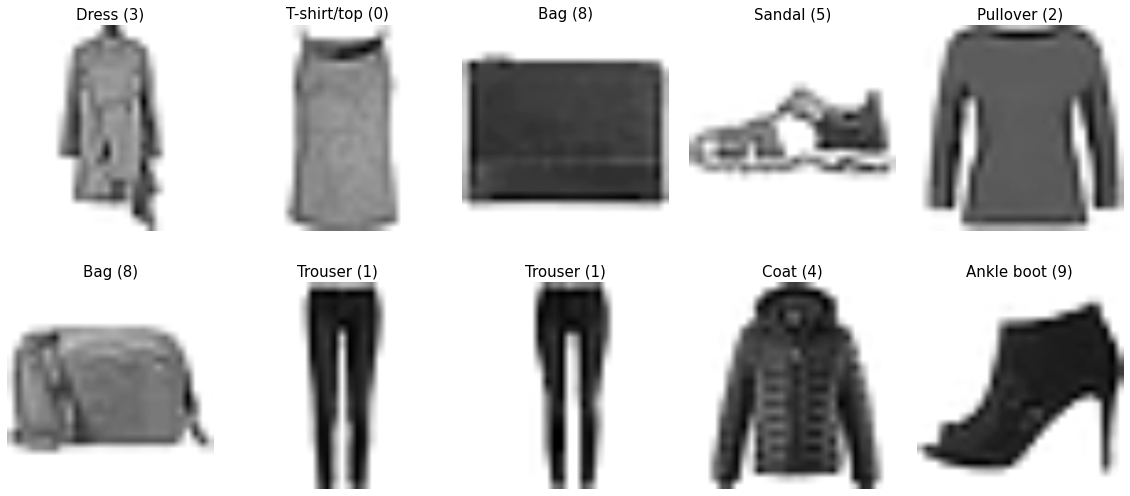

In [5]:
train_plotter = ImagePlotter(train, label=class_label)
train_plotter.grid_plot(grid_size=(2,5), figsize=(20, 10), wspace=0.1, hspace=-0.1, axis='off', title='y_one_hot')

### The AlexNet Architecture

- Adding BatchNormalization Layer instead of Local Response BatchNormalization.
- Adding Relu activation to get non-linear decision boundary.

In [6]:
def get_alex_net(img_shape=(227,227,3), n_classes=10):
    inputs = tfl.Input(shape=img_shape)
    
    # Layer 1
    model = tfl.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), kernel_regularizer=tf.keras.regularizers.l2())(inputs)
    model = tfl.BatchNormalization()(model)
    model = tfl.Activation('relu')(model)
    model = tfl.MaxPool2D(pool_size=3, strides=2)(model)

    # Layer 2
    model = tfl.Conv2D(filters=256, kernel_size=(5,5))(model)
    model = tfl.BatchNormalization()(model)
    model = tfl.Activation('relu')(model)   
    model = tfl.MaxPool2D(pool_size=3, strides=2)(model)
    
    # Layer 3 
    model = tfl.Conv2D(filters=384, kernel_size=(3,3))(model)
    model = tfl.Activation('relu')(model)   
 
    # Layer 4
    model = tfl.Conv2D(filters=384, kernel_size=(3,3))(model)
    model = tfl.Activation('relu')(model)
    
    # Layer 5
    model = tfl.Conv2D(filters=256, kernel_size=(3,3))(model)
    model = tfl.Activation('relu')(model)
    conv = tfl.MaxPool2D(pool_size=3, strides=2)(model)

    # Layer 6
    model = tfl.Flatten()(model)
    model = tfl.Dense(units=4096, activation='relu')(model)
    model = tfl.Dropout(rate=0.5)(model)
    
    # Layer 7
    model = tfl.Dense(units=4096, activation='relu')(model)
    model = tfl.Dropout(rate=0.5)(model)

    # Output Layer
    model = tfl.Dense(units=n_classes, activation='softmax')(model)

    return tf.keras.Model(inputs=inputs, outputs=model)


In [7]:
alex_net = get_alex_net(img_shape=(227,227,1), n_classes=10)
cb = Callbacks()
alex_net.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

plot_model(alex_net, to_file='alex_net.png', show_shapes=True)
alex_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 256)       1024  

In [8]:
history = alex_net.fit(train, 
                    validation_data=valid,
                    epochs=15,
                    callbacks=[cb.ModelCheckpoint(verbose=1, save_best_only=True)])

np.save("history.npy", history.history)

Epoch 1/15
469/469 [==============================] - 123s 243ms/step - loss: 1.1815 - accuracy: 0.6462 - val_loss: 0.5335 - val_accuracy: 0.8087

Epoch 00001: val_loss improved from inf to 0.53346, saving model to run-2021-05-24-16-36-34.h5
Epoch 2/15
469/469 [==============================] - 69s 146ms/step - loss: 0.4400 - accuracy: 0.8438 - val_loss: 0.3816 - val_accuracy: 0.8624

Epoch 00002: val_loss improved from 0.53346 to 0.38161, saving model to run-2021-05-24-16-36-34.h5
Epoch 3/15
469/469 [==============================] - 69s 147ms/step - loss: 0.3734 - accuracy: 0.8643 - val_loss: 0.4009 - val_accuracy: 0.8651

Epoch 00003: val_loss did not improve from 0.38161
Epoch 4/15
469/469 [==============================] - 69s 148ms/step - loss: 0.3450 - accuracy: 0.8764 - val_loss: 0.3756 - val_accuracy: 0.8681

Epoch 00004: val_loss improved from 0.38161 to 0.37558, saving model to run-2021-05-24-16-36-34.h5
Epoch 5/15
469/469 [==============================] - 69s 148ms/step - 

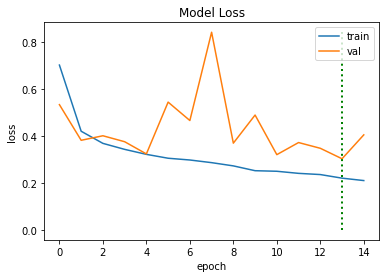

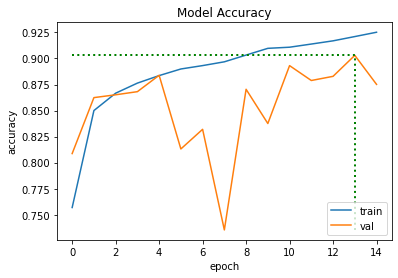

In [9]:
#history=np.load('history.npy',allow_pickle='TRUE').item()

history_plotter = HistoryPlotter(history=history.history)
history_plotter.loss(show_optimal=True)
history_plotter.metric(show_optimal=True)

In [10]:
alex_net.evaluate(test)

24/24 [==============================] - 15s 650ms/step - loss: 0.3956 - accuracy: 0.8767


[0.3956473767757416, 0.8766666650772095]

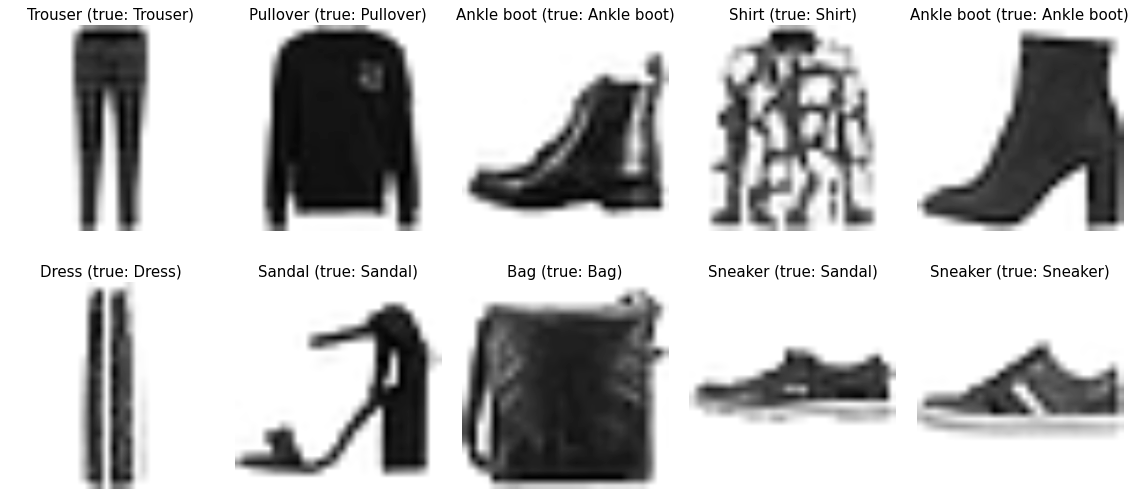

In [11]:
test_plotter = ImagePlotter(test, model=alex_net, label=class_label)
test_plotter.grid_plot(grid_size=(2,5), figsize=(20, 10), wspace=0.1, hspace=-0.1, axis='off', title='y_pred_one_hot')